In [1]:
from torch.nn.utils.rnn import pack_padded_sequence
# from torchvision.models import resnet101
import random
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.optim.lr_scheduler as scheduler
from datetime import datetime
import torchvision.models as models
# import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import os
import torchvision.models as models
import torch.nn.functional as F
# from CDCNs import Conv2d_cd
from pytorch_model_summary import summary
# import json
# from model.attention.CBAM import CBAMBlock
# from torchvision.models.resnet import Bottleneck
import pandas as pd
# from model.attention.ShuffleAttention import ShuffleAttention
# from model.attention.CBAM import CBAMBlock

from model.attention.CoordAttention import CoordAtt

In [2]:
experiment_name = '054a (main experiment)  - Neural Textures 1'

output_savepath = '/home/biometricgpu09/dhruv/outputs/'

In [3]:
trans = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])

In [4]:
def getFaceTensor3(videopath, num):
    
    vidTensor = []
    
    for i in range(num):
        
        name1 = str(i) + '.png'
        
        img = Image.open(videopath + name1)
        
        img = trans(img)
        
        vidTensor.append(img)
        
    vidTensor = torch.stack(vidTensor)
    
#     print(vidTensor.shape)
    
    return vidTensor

# getFaceTensor3('/home/ankit/datasets/DFDC/extractedfaces/0/aaqaifqrwn/', 32)

In [5]:
def countUnderScore(name):
    
    count =0
    
    for i in range(len(name)):
        
        if(name[i] == '_'):
            count += 1
            
    return count
    

In [6]:
class FFClassification(Dataset):
    
    def __init__(self, alldata, allimages, allindexpath, manipulation_type, transform = None):
               
        self.alldata = torch.load(alldata)
        
        self.folders = ['real', 'Deepfakes', 'Face2Face','FaceShifter','FaceSwap', 'NeuralTextures']
        
        self.transform = transform    
        
        print('Loading all images data')
        
        self.allimages = torch.load(allimages)
        
        print('Loading images complete')
        
        allindex = torch.load(allindexpath)
        
        self.allindex = allindex[manipulation_type]

    
    def __len__(self):
        
        return 1997

    def __getitem__(self, index):
        
        actualIndex = self.allindex[index]
        
        data = self.alldata[actualIndex]
        
        label = data['label']
        
        vidTensor = self.allimages[actualIndex]
        
        if(label != 0):
            label = 1
        
        if(self.transform):
            vidTensor = self.transform(vidTensor)

        return (vidTensor, label)

In [7]:
def resizeBatch(batchinput, batchlabel):
    
    resizedbatch = torch.flatten(batchinput, start_dim=0, end_dim=1)
    
#     print('resized batch shape : ', resizedbatch.shape)
    
    resizedlabels = torch.tensor([], dtype=torch.int64)
    
    mul = batchinput.shape[1]
#     print('mul : ', mul)
    
    for i in range(len(batchlabel)):
        
        label = torch.tensor(batchlabel[i])
        label = label.repeat(mul)
        resizedlabels = torch.cat([resizedlabels, label])
        
#     print('reshaped label shape : ', resizedlabels.shape)
#     print(resizedlabels)

    return (resizedbatch, resizedlabels)
        
# resizeBatch(a,l)       

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used for training is ",device)

Device used for training is  cuda:0


In [9]:
manipulation_types = ['real-deepfake' , 'real-f2f', 'real-faceshifter', 'real-faceswap', 'real-neuraltextures']

manipulation = manipulation_types[4]

In [10]:

alldatapath = '/home/biometricgpu09/datasets/FF++/allData.pt'

allimagespath = '/home/biometricgpu09/datasets/FF++/allImages.pt'

allindexpath = '/home/biometricgpu09/datasets/FF++/allIndexes.pt'

In [11]:
batch_size = 24

num_samples_train = 1500
num_samples_validation = 200
num_samples_test = 297

In [12]:
transformation = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                     transforms.RandomVerticalFlip()])

In [13]:
# dataset = FFClassification(rootPath, alldatapath, allimagespath,
#                            allindexpath, manipulation, 
#                            transform = transformation)

dataset = FFClassification(alldatapath, allimagespath,
                           allindexpath, manipulation, 
                           transform = transformation)


Loading all images data
Loading images complete


In [14]:
print(len(dataset))

1997


In [15]:
trainset, validationset, testset = torch.utils.data.random_split(dataset, [num_samples_train, 
                                                                           num_samples_validation, 
                                                                           num_samples_test])

In [16]:
trainloader = DataLoader(dataset = trainset, 
                         batch_size=batch_size, 
                         shuffle = True,
                         pin_memory=True)

validationloader = DataLoader(dataset = validationset, 
                              batch_size=batch_size, 
                              shuffle = True,
                              pin_memory=True)

testloader = DataLoader(dataset = testset, 
                        batch_size=batch_size,
                        shuffle = True,
                        pin_memory=True)

In [17]:
num_train_batches = len(trainloader)
num_validation_batches = len(validationloader)
num_test_batches = len(testloader)

print(num_train_batches)
print(num_validation_batches)
print(num_test_batches)

63
9
13


In [18]:
class CustomDenseNet(models.DenseNet):
    
    def __init__(self, pretrained = False):
        
        super(CustomDenseNet, self).__init__(growth_rate = 32, 
                                             block_config = (6, 12, 24, 16),
                                            num_init_features = 64)
        
        if(pretrained):
            pretrained_dict = pretrained.state_dict()
            self.load_state_dict(pretrained_dict)
            print('Pretrained weights loaded successfully')
        else:
            print('No pretrained weights loaded')
            
        self.classifier = nn.Linear(448, 2, bias = True)
        
        self.features.denseblock3 = nn.Identity()
        self.features.transition3 = nn.Identity()        
        self.features.denseblock4 = nn.Identity()        
        
        self.features.transition1.conv = nn.Conv2d(256,64,1)         
        self.features.transition2.conv = nn.Conv2d(512,128,1)        
#         self.features.transition3.conv = nn.Conv2d(1024,256,1)
        
        
        self.att1 = CoordAtt(128 , 128 , reduction = 32)
        self.att2 = CoordAtt(256 , 256 , reduction = 32)
#         self.att3 = CoordAtt(512 , 512 , reduction = 32)
        
        self.att4 = CoordAtt(448 , 448 , reduction = 32)
        
#         self.conv01 = nn.Conv2d(320 , 256 , 1)
#         self.conv02 = nn.Conv2d(640 , 512 , 1)
#         self.conv04 = nn.Conv2d(1024 , 512 , 1)
    
        self.residualMP1 = nn.MaxPool2d(4,4)
        self.residualMP2 = nn.MaxPool2d(2,2)
#         self.residualMP3 = nn.MaxPool2d(2,2)
        
#         self.conv05 = nn.Conv2d(1984 , 1024 , 1)
        
        
    def forward(self, x):
        
        x = self.features.conv0(x)
        x = self.features.norm0(x)
        x = self.features.relu0(x)
        x = self.features.pool0(x)
        
        x1 = x
        
#         print('Shape before db1 : ', x.shape)
        
        x = self.features.denseblock1(x)
        x = self.features.transition1.norm(x)
        x = self.features.transition1.relu(x)
        x = self.features.transition1.conv(x)        
        x = x1 - x
        residual1 = x
#         print('residual shape : ', x.shape)
        
        x = torch.cat((x1, x),1)
        x = self.att1(x)
        x = self.features.transition1.pool(x)
        
#         
#         x = self.conv01(x)
        
#         print('Shape after db1 : ', x.shape)       
        
#         x = self.features.transition1(x)
        
        x2 = x
        
#         print('Shape after t1 : ', x.shape)
        
        x = self.features.denseblock2(x)
        x = self.features.transition2.norm(x)
        x = self.features.transition2.relu(x)
        x = self.features.transition2.conv(x)        
        x = x2 - x        
        residual2 = x
#         print('residual shape : ', x.shape)
        
        x = torch.cat((x2, x),1)
        x = self.att2(x)
        x = self.features.transition2.pool(x)
        
        
#         
#         print('shape : ', x.shape)
#         x = self.conv02(x)
        
#         print('Shape after db2 : ', x.shape)
#         x = self.features.transition2(x)
#         print('Shape after t2 : ', x.shape)
        
#         x3 = x
        
        x = self.features.denseblock3(x)
        x = self.features.transition3(x)
#         x = self.features.transition3.norm(x)
#         x = self.features.transition3.relu(x)
#         x = self.features.transition3.conv(x)        
#         x = x3 - x   
#         residual3 = x
# #         print('residual shape : ', x.shape)
        
#         x = torch.cat((x3, x),1)
#         x = self.att3(x)
#         x = self.features.transition3.pool(x)
        
#         x = torch.cat((x3, x),1)
#         
        
#         x = self.conv03(x)
        
#         print('Shape after db3 : ', x.shape)
#         x = self.features.transition3(x)
#         print('Shape after t3 : ', x.shape)
        
#         x4 = x
        x = self.features.denseblock4(x)
    
#         print('Shape after DB2 & T2 : ', x.shape)
        
#         xx = self.conv04(x)
#         residual4 = x4 - xx
#         print('residual shape : ', residual4.shape)
#         print('Shape after db4 : ', x.shape)
        
        residual1 = self.residualMP1(residual1)
        residual2 = self.residualMP2(residual2)
#         residual3 = self.residualMP3(residual3)
        
        allresidual = torch.cat((residual1,residual2), 1)
#         allresidual = torch.cat((residual1,residual2,residual3), 1)
#         allresidual = torch.cat((residual1,residual2,residual3,residual4), 1)
#         print('shape of all residual concatenated : ', allresidual.shape)
#         print(x.shape)
        
        
        
        out = torch.cat((x, allresidual), 1)
        
        out = F.relu(out)
        
        out = self.att4(out)
        
#         print('Concat shape : ', out.shape)
        
#         out = self.conv05(out)
        
#         print('shape before avg pool : ', out.shape)
        out = F.adaptive_avg_pool2d(out, (1, 1))
#         print('shape after avg pool : ', out.shape)
        out = torch.flatten(out, 1)
#         print('shape after flattening : ', out.shape)
        out = self.classifier(out)
        
        return out
        
        

In [19]:
model = CustomDenseNet(pretrained = models.densenet121(pretrained=True))


/home/biometricgpu09/anaconda3/envs/ankit/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/biometricgpu09/anaconda3/envs/ankit/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pretrained weights loaded successfully


In [20]:
aa = torch.rand(16,3,128,128)
o1 = model(aa)

print(o1.shape)

torch.Size([16, 2])


In [21]:
print(summary(model, torch.rand(16,3,128,128)))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1      [16, 64, 64, 64]           9,408           9,408
     BatchNorm2d-2      [16, 64, 64, 64]             128             128
            ReLU-3      [16, 64, 64, 64]               0               0
       MaxPool2d-4      [16, 64, 32, 32]               0               0
     _DenseBlock-5     [16, 256, 32, 32]         335,040         335,040
     BatchNorm2d-6     [16, 256, 32, 32]             512             512
            ReLU-7     [16, 256, 32, 32]               0               0
          Conv2d-8      [16, 64, 32, 32]          16,448          16,448
        CoordAtt-9     [16, 128, 32, 32]           3,352           3,352
      AvgPool2d-10     [16, 128, 16, 16]               0               0
    _DenseBlock-11     [16, 512, 16, 16]         919,680         919,680
    BatchNorm2d-12     [16, 512, 16, 16]          

In [22]:
model

CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [23]:
count = 0
for parameter in model.parameters():
    count += 1
    
#     parameter.requires_grad = False
    
print(count)

147


In [24]:
model.to(device)
model = nn.DataParallel(model)

In [25]:
lossFunction = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# optimizer = optim.SGD(model.parameters(), lr=0.001)

decayLR = scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

sig = nn.Sigmoid()

softmax = nn.Softmax(dim=1)

In [26]:
epochs = 30

losses=[]
vacc = []
vlosses = []

for j in range(epochs):
    
    epoch_start = datetime.now()
    
    add_loss = 0.0
    run_loss2 = 0
    
    for i,data in enumerate(trainloader):
        
#         s1 = datetime.now()
        
#         if( i!= 0):
#             print('Time : ', (s1-s4).total_seconds())
        
        image, label = data
        
        image, label = resizeBatch(image, label)
    
        image = image.to(device)
#         ids = ids.to(device)
        label = label.to(device)
        
#         image = torch.transpose(image, 1,2)
        
#         image = torch.transpose(image, 1,2)
    
        optimizer.zero_grad()
        
#         s3 = datetime.now()
    
        output = model(image)
        
#         print(output.shape)
    
        loss = lossFunction(output, label)
        
        add_loss += loss.item()
        run_loss2 += loss.item()
        
        loss.backward()
        
        optimizer.step()
        
        if(i % 10 == 9):
            print('Epoch %d, Batch %d, Loss %.8f ' % (j+1, i+1, add_loss / 10))
#             s2 = datetime.now()
#             print('Read time : ', (s3 - s1).total_seconds())
#             print('Batch time : ', (s2-s1).total_seconds())
#             print('-------')
            add_loss = 0.0    
    
#         s4 = datetime.now()
    
    losses.append(run_loss2 / num_train_batches)
    
    print('------------')
    print('Validating')
    print('------------')
    
    total = 0
    correct = 0
    vrun_loss=0
    
    model.eval()
    
    with torch.no_grad():
        
        add_vloss = 0.0
        
        for k, vdata in enumerate(validationloader):
            
            val_image, val_label = vdata
            
            val_image, val_label = resizeBatch(val_image, val_label)
            
            val_image = val_image.to(device)
#             val_of = val_of.to(device)
            val_label = val_label.to(device)
            
#             val_image = torch.transpose(val_image, 1,2)
            
            val_output = model(val_image)
            
            vloss = lossFunction(val_output, val_label)
            
            add_vloss += vloss.item()
            vrun_loss += vloss.item()
            
            if(k%10 == 9):
                print('Validation loss : ', add_vloss / 10)
                add_vloss = 0.0
            
            class_probability, class_prediction = torch.max(val_output, 1)
            
            total += len(val_label)
            
            correct += (class_prediction == val_label).sum().item()
            
        val_accuracy = correct / total
        
        vlosses.append(vrun_loss / num_validation_batches)
        vacc.append(val_accuracy)
        print('---------')
        print('Correct : ', correct)
        print('Total : ', total)
        print('Final Validation accuracy : ', val_accuracy)
        print('---------')
        epoch_end = datetime.now()
        print('Epoch time : ', (epoch_end - epoch_start).total_seconds())
        print('---------------------------------')
        
    model.train()
    decayLR.step()
    
    print('Previous Learning Rate : ', decayLR.get_last_lr())
#     aa1, aa2 = model.module.getAlpha()
#     alpha1List.append(aa1)
#     alpha2List.append(aa2)

    print('------------------------')

/home/biometricgpu09/anaconda3/envs/ankit/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch 1, Batch 10, Loss 0.69373332 
Epoch 1, Batch 20, Loss 0.69202223 
Epoch 1, Batch 30, Loss 0.69469517 
Epoch 1, Batch 40, Loss 0.69265889 
Epoch 1, Batch 50, Loss 0.69167918 
Epoch 1, Batch 60, Loss 0.69006351 
------------
Validating
------------
---------
Correct :  3180
Total :  6400
Final Validation accuracy :  0.496875
---------
Epoch time :  36.018408
---------------------------------
Previous Learning Rate :  [9.900000000000001e-05]
------------------------
Epoch 2, Batch 10, Loss 0.68589116 
Epoch 2, Batch 20, Loss 0.68096479 
Epoch 2, Batch 30, Loss 0.67847211 
Epoch 2, Batch 40, Loss 0.68401340 
Epoch 2, Batch 50, Loss 0.67348426 
Epoch 2, Batch 60, Loss 0.66468331 
------------
Validating
------------
---------
Correct :  3328
Total :  6400
Final Validation accuracy :  0.52
---------
Epoch time :  29.099548
---------------------------------
Previous Learning Rate :  [9.801e-05]
------------------------
Epoch 3, Batch 10, Loss 0.65624114 
Epoch 3, Batch 20, Loss 0.635571

Epoch 18, Batch 40, Loss 0.23794006 
Epoch 18, Batch 50, Loss 0.28779733 
Epoch 18, Batch 60, Loss 0.28229011 
------------
Validating
------------
---------
Correct :  5327
Total :  6400
Final Validation accuracy :  0.83234375
---------
Epoch time :  28.736473
---------------------------------
Previous Learning Rate :  [8.345137614500879e-05]
------------------------
Epoch 19, Batch 10, Loss 0.25116936 
Epoch 19, Batch 20, Loss 0.24723910 
Epoch 19, Batch 30, Loss 0.24441688 
Epoch 19, Batch 40, Loss 0.24796595 
Epoch 19, Batch 50, Loss 0.22769598 
Epoch 19, Batch 60, Loss 0.24414603 
------------
Validating
------------
---------
Correct :  5474
Total :  6400
Final Validation accuracy :  0.8553125
---------
Epoch time :  29.50662
---------------------------------
Previous Learning Rate :  [8.26168623835587e-05]
------------------------
Epoch 20, Batch 10, Loss 0.26493097 
Epoch 20, Batch 20, Loss 0.24405640 
Epoch 20, Batch 30, Loss 0.28190321 
Epoch 20, Batch 40, Loss 0.22908480 
Ep

# Testing

In [27]:
correct = 0
total = 0

all_test_labels = torch.tensor([]).to(device)
all_predicted_test_labels = torch.tensor([]).to(device)
all_predicted_test_probabilities = torch.tensor([]).to(device)
all_predicted_fake_probabilities = torch.tensor([]).to(device)

with torch.no_grad():
    
    for i, data in enumerate(testloader):
        
        test_image, test_label = data
        
        test_image, test_label = resizeBatch(test_image, test_label)
        
        test_image = test_image.to(device)
#         test_of = test_of.to(device)        
        test_label = test_label.to(device)
        
        all_test_labels = torch.cat([all_test_labels, test_label])
        
        test_output = model(test_image)
        
        test_output2 = softmax(test_output)
        
        test_output3, _ = torch.max(test_output2, dim=1)

        
#         print('Output on Test Batch')
#         print(test_output.shape)
#         print('------------------------')
        
        loss = lossFunction(test_output, test_label)
        
#         print('Loss value : ', loss.item())
#         print('Acutal Labels : ', test_label)
        
        
        class_probability, class_prediction = torch.max(test_output, 1)
        
#         print('Predicted Label : ', class_prediction)
#         print('-----------------')
        
        all_predicted_test_labels = torch.cat([all_predicted_test_labels, class_prediction])
        
        all_predicted_test_probabilities = torch.cat([all_predicted_test_probabilities, test_output3])
        
        all_predicted_fake_probabilities = torch.cat([all_predicted_fake_probabilities, test_output2[:, 1]])
        
        total += len(test_label)
        
        correct += (class_prediction == test_label).sum().item()
        
    final_test_accuracy = correct/total
    
    print('Correct : ', correct)
    print('Total : ', total)
    print('Test accuracy is ', final_test_accuracy)

/home/biometricgpu09/anaconda3/envs/ankit/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Correct :  8057
Total :  9504
Test accuracy is  0.8477483164983165


# Calculate confusion matrix and save to file

In [28]:
from sklearn.metrics import confusion_matrix

confusionMatrix = confusion_matrix(all_test_labels.cpu(), all_predicted_test_labels.cpu(), labels = range(2))

print(confusionMatrix)

confusionmatrixpath = output_savepath + experiment_name + '-confusionmatrix.pt'

confusion_dictionary = {0:confusionMatrix}

torch.save(confusion_dictionary, confusionmatrixpath)


[[3800  872]
 [ 575 4257]]


# Plot confusion matrix

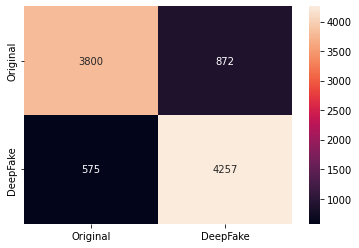

In [29]:
import seaborn as sns

# confusionMatrixPath = '/home/ankit/code/k/figures/'

# plot_name = 'confusion' + '_' + feature1 + '_' + feature2 + '_' + feature3 + '_' + str(int(a1*100)) + '_' + str(int(a2*100)) + '_' + str(int(a3*100)) + '.png'

# sns.set(rc={'figure.figsize':(13.7,10.27)})

ax = sns.heatmap(confusionMatrix, annot = True, 
                 xticklabels=['Original', 'DeepFake'], 
                 yticklabels=['Original', 'DeepFake'],
                 fmt='d')

fig = ax.get_figure()

# fig.savefig(confusionMatrixPath + plot_name)

# MCC



In [30]:
from sklearn import metrics

mcc2 = metrics.matthews_corrcoef(all_test_labels.cpu(), all_predicted_test_labels.cpu())
print(mcc2)

0.6964546343808992


# calc precision, recall, f1

In [31]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels.cpu(), 
                                                           all_predicted_test_labels.cpu(), 
                                                           labels = range(2),
                                                           average = 'binary')

precision, recall, f1

(0.8299863521154222, 0.8810016556291391, 0.8547334604959341)

# calc AUC score

In [32]:
from sklearn import metrics

auc_score = metrics.roc_auc_score(all_test_labels.cpu(), 
                                  all_predicted_fake_probabilities.cpu(), 
                                  
                                  )

print(auc_score)

0.9291265723515603


# Save all metrics in a dictionary

In [33]:
metrics_dictionary = {}

metrics_dictionary['accuracy'] = final_test_accuracy
metrics_dictionary['precision'] = precision
metrics_dictionary['recall'] = recall
metrics_dictionary['f1'] = f1
metrics_dictionary['auc'] = auc_score
metrics_dictionary['mcc'] = mcc2

savefullpath = output_savepath + experiment_name + '-result-metrics.pt'

torch.save(metrics_dictionary, savefullpath)

metrics_dictionary

{'accuracy': 0.8477483164983165,
 'precision': 0.8299863521154222,
 'recall': 0.8810016556291391,
 'f1': 0.8547334604959341,
 'auc': 0.9291265723515603,
 'mcc': 0.6964546343808992}

# calculate TPR and FPR for ROC AUC curve

In [34]:
fpr2, tpr2, threshold = metrics.roc_curve(all_test_labels.cpu(), 
                                  all_predicted_fake_probabilities.cpu(), pos_label = 1)

print(tpr2)
print((fpr2))
print(len(threshold))

[0.00000000e+00 2.06953642e-04 8.27814570e-04 ... 9.99793046e-01
 1.00000000e+00 1.00000000e+00]
[0.         0.         0.         ... 0.95911815 0.95911815 1.        ]
1970


# save TPR and FPR for auc roc

In [35]:
tprfprsavepath = output_savepath + experiment_name + ' AUC Values.csv'

pd.DataFrame({'False Positive Rate': fpr2, 'True Positive Rate':tpr2, 'Threshold': threshold}).to_csv(tprfprsavepath, index=False)

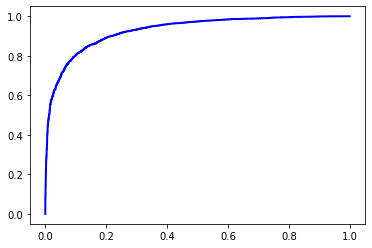

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.axes()

ax.plot(fpr2, tpr2, color='blue',  linewidth=2 )

# save and plot training curves - train loss, val loss and val acc

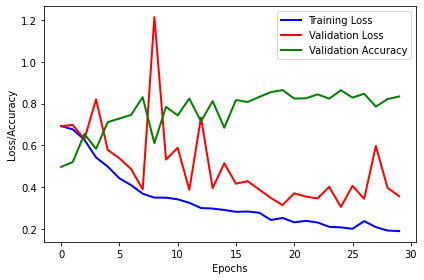

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-bright')

fig = plt.figure()

# fig.set_size_inches(15.5, 10.5)

ax = plt.axes()

x_values = range(epochs)

losses2 = torch.tensor(losses).cpu()
vlosses2 = torch.tensor(vlosses).cpu()
vacc2 = torch.tensor(vacc).cpu()

ax.plot(x_values, losses2, color='blue',  linewidth=2, label='Training Loss' )
ax.plot(x_values, vlosses2, color='red',  linewidth=2, label='Validation Loss')
ax.plot(x_values, vacc2, color='green',  linewidth=2, label='Validation Accuracy')


plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.tight_layout()

plotsavepath = output_savepath + experiment_name + ' training curve values.csv'

pd.DataFrame({'epochs': x_values, 'train loss':losses, 
              'validation loss': vlosses,
             'validation accuracy': vacc}).to_csv(plotsavepath, index=False)


# save model weights

In [38]:
modelsavepath = output_savepath + experiment_name + ' saved model.pt'

torch.save(model.state_dict(), modelsavepath)